In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.framework import ops
import math
from tensorflow.python.saved_model import tag_constants

C:\Users\ankit\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Cleaning the Data we have


In [2]:
# Import the data
df = pd.read_csv("Beer Train Data Set.csv", na_values='NaN')
df['ABV'] = df['ABV'].fillna(df['ABV'].mean())
print('Shape of the Data: ' + str(df.shape))

df['Ratings'] = pd.to_numeric(df['Ratings'], errors = 'coerce')
df['Ratings'] = df['Ratings'].replace(np.nan, 1.0)
ratings_score = df.loc[:,['Ratings', 'Score']]
df_use = df[ratings_score['Ratings'] != 0]


col_to_encode = ['Style Name']
col_to_scale = np.array(['ABV', 'Brewing Company', 'Beer Name'])

Shape of the Data: (185643, 10)


In [3]:
# Labelling features and target
x_raw = df_use.loc[:,col_to_encode+list(col_to_scale)]
y = df_use.loc[:,['Score']]

In [4]:
# Splitting the data into train and dev sets
X_train_raw, X_dev_raw, Y_train, Y_dev = train_test_split(x_raw, y, test_size=0.10, random_state=42)

In [5]:
def one_hot_encode(df, col_to_encode):
    """Returns One Hot encoded column"""
    
    cat_col = df[col_to_encode]
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(cat_col)
    integer_encoded = integer_encoded.reshape(len(integer_encoded),1)
    
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    
    return one_hot_encoded
    
def scale_col(df, col_to_scale):
    """Returns a scaled dataframe"""
    
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df[col_to_scale])
        
        
    return scaled_df

def process_data(df, col_to_scale, col_to_encode):
    """Transforms the dataframe into a standard dataframe
    with scaled and one hot encoded columns"""
    
    index = list(range(0,94)) + list(col_to_scale)
    processed_df = pd.DataFrame()
    scaled_df = scale_col(df, col_to_scale)
    one_hot_encoded = one_hot_encode(df, col_to_encode)
    processed_data = np.concatenate([one_hot_encoded, scaled_df], axis = 1) 
    processed_df = pd.DataFrame(processed_data, columns = index)
    
    
    return processed_df

In [6]:
X_train = process_data(X_train_raw, col_to_scale, col_to_encode)
X_dev = process_data(X_dev_raw, col_to_scale, col_to_encode)

print('X_train shape: ' + str(X_train.shape))
print('X_dev shape: ' + str(X_dev.shape))

C:\Users\ankit\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train shape: (143597, 97)
X_dev shape: (15956, 97)


# Implementing the model using Tensorflow

In [7]:
# Reshaping the trainig and dev data
X_train = X_train.T
X_dev = X_dev.T
Y_train = Y_train.T
Y_dev = Y_dev.T
print("number of training examples = " + str(X_train.shape[1]))
print("number of dev examples = " + str(X_dev.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_dev shape: " + str(X_dev.shape))
print("Y_dev shape: " + str(Y_dev.shape))

assert(X_train.shape[0] == X_dev.shape[0])
assert(X_train.shape[1] == Y_train.shape[1])
assert(X_train.shape[0] < 100)

number of training examples = 143597
number of dev examples = 15956
X_train shape: (97, 143597)
Y_train shape: (1, 143597)
X_dev shape: (97, 15956)
Y_dev shape: (1, 15956)


In [13]:
# Create placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [14]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(layer_dims):
    """
    Initializes parameters to build a neural network with tensorflow.
                       
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    parameters={}
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = tf.get_variable(("W"+str(l)), [layer_dims[l], layer_dims[l-1]], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        parameters['b' + str(l)] = tf.get_variable("b"+str(l), [layer_dims[l], 1], initializer = tf.zeros_initializer())

 
    return parameters

In [15]:
minibatch_size = 200
layer_dims = layer_dims=[X_train.shape[0], 25, 12, 6, 1]
num_epochs = 2000
parameters = {}
lambd = 0.5

In [16]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    
    Returns:
    the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    
    return Z4

In [84]:
def compute_cost(Z4, Y, parameters, lambd):
    """
    Computes the cost
    
    Arguments:
    Z4 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z4
    
    Returns:
    cost - Tensor of the cost function
    """
    
    m = 143597
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    
    cost = tf.sqrt(tf.losses.mean_squared_error(Z4, Y))
    
     
    #L2_regularization_cost = (lambd/2*m) * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4))
    
    tot_cost = cost #+ L2_regularization_cost
    
    return tot_cost

In [85]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    X = X.as_matrix()
    Y = Y.as_matrix()
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [86]:
def model(X_train, Y_train, X_dev, Y_dev, layer_dims=[X_train.shape[0], 25, 12, 6, 1], learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 200, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    parameters = {}
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
   
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z4, Y, parameters, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 200 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Dev Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        
        return parameters


C:\Users\ankit\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\ankit\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Cost after epoch 0: 3.634329
Cost after epoch 200: 0.384099
Cost after epoch 400: 0.383419


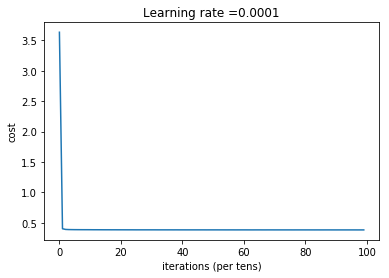

Parameters have been trained!
Train Accuracy: 1.0
Dev Accuracy: 1.0


In [87]:
parameters = model(X_train, Y_train, X_dev, Y_dev)

In [88]:
# Calculated Parameters:
print(parameters)

{'W3': array([[-5.40546775e-01, -5.71775973e-01, -5.77599227e-01,
        -2.81543463e-01,  1.34015009e-01,  6.76653832e-02,
         4.23391789e-01, -1.26005962e-01, -1.09027907e-01,
        -1.37332052e-01, -3.10035914e-01, -1.33529246e-01],
       [ 5.10601938e-01,  2.55869597e-01, -3.36061716e-02,
         1.01884198e+00,  2.25830227e-01,  2.98424035e-01,
        -3.50059956e-01, -8.06941807e-01,  8.10044706e-01,
        -3.15483779e-01,  9.16739851e-02,  4.11973685e-01],
       [-1.65896118e-01, -1.06338926e-01, -4.42245811e-01,
        -4.33360189e-02, -3.09423238e-01, -3.67327183e-01,
         2.24966466e-01, -2.36748420e-02,  1.17421150e-04,
        -2.13919610e-01, -5.04919253e-02,  1.16991848e-02],
       [-3.89023662e-01,  3.23603004e-01,  7.27356672e-02,
        -7.79896751e-02, -5.20048857e-01, -1.93464637e-01,
         3.61025006e-01, -1.77164003e-01, -2.32709587e-01,
        -4.58137304e-01, -1.42096236e-01, -5.01641273e-01],
       [ 7.34000266e-01, -2.98566699e-01,  2.

In [89]:
# Input the test data:
test_raw = pd.read_csv('Beer Test Data Set.csv', na_values=np.nan)
test_raw = test_raw.fillna(0)
print('Shape of the Test Data: ' + str(test_raw.shape))
test_raw.head()

Shape of the Test Data: (20628, 10)


,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score
0,6.2,8803,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",34558,3,AmericanIPA,40-45,45-50,0.0
1,5.3,8558,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",86826,20,AmericanPorter,40-45,45-50,0.0
2,7.0,7519,"Cheese(earthyCamembert,Fontina)General(Aperitif)","Snifter,Tulip,OversizedWineGlass",17051,0,BelgianDarkAle,45-50,45-50,0.0
3,5.2,9852,"(LatinAmerican,German)Meat(Pork,Poultry)","Flute,PilsenerGlass(orPokal),Mug(orSeidel,Stein)",49156,2,ViennaLager,35-40,40-45,0.0
4,8.1,8991,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",162723,5,AmericanPorter,40-45,45-50,0.0


In [90]:
test_raw['Ratings'] = pd.to_numeric(test_raw['Ratings'], errors = 'coerce')
test_raw['Ratings'] = test_raw['Ratings'].replace(np.nan, 1.0)
ratings = test_raw.loc[:,['Ratings']]
test_nonzero = test_raw[ratings['Ratings'] != 0]

In [91]:
test_use = test_nonzero.loc[:,col_to_encode+list(col_to_scale)]
test_norm = process_data(test_use, col_to_scale, col_to_encode) 
test_norm = test_norm.astype('float32').T

C:\Users\ankit\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [92]:
test_norm.shape

(97, 17642)

In [93]:
temp = forward_propagation(test_norm, parameters)
with tf.Session() as sess:
    values = temp.eval()
values_list = values.tolist()[0]

In [94]:
len(values_list)

17642

In [95]:
def value_generator(values_list):
    for value in values_list:
        yield value
        
value = value_generator(values_list)


In [96]:
predicted_values = []
try:
    for i, status in enumerate(ratings['Ratings']==0):
        if ratings.iloc[i, :].item() == 0:
            predicted_values.append(0.0)
        else:
            predicted_values.append(next(value))
except StopIteration:
    pass

In [97]:
values_list

[3.866166830062866,
 3.7683444023132324,
 3.540391206741333,
 3.8409583568573,
 4.009626388549805,
 4.0543317794799805,
 2.9862139225006104,
 3.9763293266296387,
 3.789870023727417,
 3.7154409885406494,
 3.815401315689087,
 3.9896013736724854,
 3.5048015117645264,
 3.5362794399261475,
 3.4976389408111572,
 3.897258996963501,
 3.896641492843628,
 3.71805739402771,
 3.0221126079559326,
 3.8510100841522217,
 3.2057695388793945,
 3.5752127170562744,
 3.8971145153045654,
 3.6277174949645996,
 4.066475868225098,
 3.5949461460113525,
 3.661794900894165,
 3.870958089828491,
 3.7018470764160156,
 3.7025372982025146,
 3.775808811187744,
 3.8267438411712646,
 3.553178548812866,
 3.821864366531372,
 3.9019672870635986,
 3.7437942028045654,
 3.736920118331909,
 3.803417444229126,
 3.8591089248657227,
 3.716827154159546,
 3.056966543197632,
 3.8754734992980957,
 2.7215960025787354,
 3.689203977584839,
 3.989039659500122,
 3.7306768894195557,
 3.590235471725464,
 3.748295783996582,
 3.649200677871704

In [99]:
# Saving the data in to a xlsx file as prescibed by Machine Hack
Beer_Score = pd.DataFrame(predicted_values, columns=['Score'])
writer = pd.ExcelWriter('Predicted Score.xlsx')
Beer_Score['Score'].to_excel(writer, 'Sheet1')
writer.save()